# WEATHER data from Warsaw station

In [31]:
import pandas as pd
from matplotlib import pyplot
import seaborn as sn
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime as dt
import numpy as np

from tensorflow import keras


# Read the CSV file
all_data = pd.read_csv("data_ready_for_training.csv")
all_data.head()

,Unnamed: 0,relh,sknt,temp,day,month,year,time
0,0,92.97,10.0,0.0,1,1,2015,01:00:00
1,2,100.00,7.0,0.0,1,1,2015,02:00:00
2,4,100.00,7.0,0.0,1,1,2015,03:00:00
3,6,93.03,6.0,1.0,1,1,2015,04:00:00
4,8,100.00,7.0,1.0,1,1,2015,05:00:00


In [29]:
import warnings
warnings.filterwarnings("ignore") #:D

### Note - columns:

valid:
timestamp of the observation - every half hour

tmpf:
Air Temperature in Fahrenheit

relh:
Relative Humidity in %

drct:
Wind Direction in degrees from *true* north

sknt:
Wind Speed in knots

p01i:
One hour precipitation for the period from the observation time to the time of the previous hourly precipitation reset. This varies slightly by site. Values are in inches. This value may or may not contain frozen precipitation melted by some device on the sensor or estimated by some other means. Unfortunately, we do not know of an authoritative database denoting which station has which sensor.



In [38]:
df_with_direct = all_data[["relh","sknt","temp","day","month","year","time"]]

df_with_direct=df_with_direct.replace('M', np.nan)

nan_count = df_with_direct.isna().sum()

print(nan_count)

relh     0
sknt     0
temp     0
day      0
month    0
year     0
time     0
dtype: int64


In [69]:
# drct deletion
df = df_with_direct.copy()

# 'tmpf' NaN into data from previous timestamp
bool_df = df['temp'].isnull()
indexes = df[bool_df].index
for i in indexes:
    df['temp'][i]=df['temp'][i-1]

# 'tmpf' NaN into data from previous timestamp
bool_df = df['relh'].isnull()
indexes = df[bool_df].index
for i in indexes:
    df['relh'][i]=df['relh'][i-1]

# 'tmpf' NaN into data from previous timestamp
bool_df = df['sknt'].isnull()
indexes = df[bool_df].index
for i in indexes:
    df['sknt'][i]=df['sknt'][i-1]

nan_count = df.isna().sum()

print(nan_count)

relh     0
sknt     0
temp     0
day      0
month    0
year     0
time     0
dtype: int64


In [70]:
#Fahrenheit => Celsius

df['temp'] = df['temp'].astype(float)
df['relh'] = df['relh'].astype(float)
df['sknt'] = df['sknt'].astype(float)
df['day'] = df['day'].astype(int)
df['month'] = df['month'].astype(int)
df['year'] = df['year'].astype(int)
df['time'] = df['time'].apply(lambda x: int(x[:2]))
df = df.assign(tempc = lambda x: (5/9)*(x['temp']-32))
df.drop(['temp'], axis=1, inplace=True)
# date
# df['valid']=pd.to_datetime(df['valid'])
# df['day'] = df['valid'].dt.day
# df['month'] = df['valid'].dt.month
# df['year'] = df['valid'].dt.year
# df['time'] = df['valid'].dt.time

#dates = df['valid']


df.head()

,relh,sknt,day,month,year,time,tempc
0,92.97,10.0,1,1,2015,1,-17.777778
1,100.00,7.0,1,1,2015,2,-17.777778
2,100.00,7.0,1,1,2015,3,-17.777778
3,93.03,6.0,1,1,2015,4,-17.222222
4,100.00,7.0,1,1,2015,5,-17.222222


### from 2015 to 2021 weather : 2022 for validation

In [73]:
# for learning
df_2015_2021 = df[(df['year'] <= 2021)]
# dates_2015_2021 = dates[df['year'] <= 2021]

# for validation
df_2022 = df[(df['year'] == 2022)]
# dates_2022 = dates[df['year'] == 2022]

df_2015_2021

,relh,sknt,day,month,year,time,tempc
0,92.97,10.0,1,1,2015,1,-17.777778
1,100.00,7.0,1,1,2015,2,-17.777778
2,100.00,7.0,1,1,2015,3,-17.777778
3,93.03,6.0,1,1,2015,4,-17.222222
4,100.00,7.0,1,1,2015,5,-17.222222
...,...,...,...,...,...,...,...
61252,87.37,11.0,31,12,2021,19,-12.222222
61253,87.37,9.0,31,12,2021,20,-12.222222
61254,93.50,15.0,31,12,2021,21,-12.222222
61255,93.50,17.0,31,12,2021,22,-12.222222


# XGBoost model

In [51]:
def gethour(x):
    return x.hour

In [74]:
#xgboost
x_train_xgb = df_2015_2021[["relh", "tempc", "sknt", "day", "month", "year", "time"]]
#x_train_xgb["hour"]=np.vectorize(gethour)(x_train_xgb["time"])
#x_train_xgb["hour"] = df['hour'].astype(int)
x_train_xgb = x_train_xgb.iloc[::2, :].reset_index(names='index', drop=True) 
#x_train_xgb.drop(axis="columns", inplace=True,labels="time")

#x_train_xgb["time"]=int(datetime.datetime.timestamp(datetime.datetime.utcnow()))
y_train_xgb = x_train_xgb.iloc[2:]
#y_train_xgb.drop(axis="columns", inplace=True,labels=["day", "month", "year", "hour"])
x_train_xgb = x_train_xgb.iloc[:-2]

x_test_xgb = df_2022[["relh", "tempc", "sknt", "day", "month", "year", "time"]]
#x_test_xgb["hour"]=np.vectorize(gethour)(x_test_xgb["time"])
#x_test_xgb["hour"] = df['hour'].astype(int)
x_test_xgb = x_test_xgb.iloc[::2, :].reset_index(names='index', drop=True) 
#x_test_xgb.drop(axis="columns", inplace=True,labels="time")

y_test_xgb = x_test_xgb.iloc[2:]
#y_test_xgb.drop(axis="columns", inplace=True,labels=["day", "month", "year", "hour"])
x_test_xgb = x_test_xgb.iloc[:-2]
#int(pd.Timestamp(datetime.datetime.timestamp(x_train_xgb["time"][0].time)))
#x_train_xgb["hour"]=np.vectorize(gethour)(x_train_xgb["time"])
#x_train_xgb = x_train_xgb.iloc[::2, :].reset_index(names='index', drop=True) 
#x_train_xgb.drop(axis="columns", inplace=True,labels="time")
x_train_xgb, y_train_xgb, x_test_xgb, y_test_xgb

(         relh      tempc  sknt  day  month  year  time
 0       92.97 -17.777778  10.0    1      1  2015     1
 1      100.00 -17.777778   7.0    1      1  2015     3
 2      100.00 -17.222222   7.0    1      1  2015     5
 3      100.00 -17.222222   8.0    1      1  2015     7
 4      100.00 -16.666667  10.0    1      1  2015     9
 ...       ...        ...   ...  ...    ...   ...   ...
 30622   93.55 -11.666667  17.0   31     12  2021    11
 30623   87.47 -11.666667  17.0   31     12  2021    13
 30624   93.50 -12.222222  13.0   31     12  2021    15
 30625   87.37 -12.222222  12.0   31     12  2021    17
 30626   87.37 -12.222222  11.0   31     12  2021    19
 
 [30627 rows x 7 columns],
          relh      tempc  sknt  day  month  year  time
 2      100.00 -17.222222   7.0    1      1  2015     5
 3      100.00 -17.222222   8.0    1      1  2015     7
 4      100.00 -16.666667  10.0    1      1  2015     9
 5      100.00 -16.666667   9.0    1      1  2015    11
 6      100.00 -16.

In [65]:
import xgboost as xgb

In [75]:
reg = xgb.XGBRegressor(
        tree_method="hist",
        n_estimators=100,
        n_jobs=16,
        max_depth=9,
        multi_strategy="multi_output_tree",
        subsample=0.6,
    )
reg.fit(y_train_xgb, y_train_xgb, eval_set=[(x_test_xgb, y_test_xgb)])

[0]	validation_0-rmse:491.92908
[1]	validation_0-rmse:344.84072
[2]	validation_0-rmse:241.88556
[3]	validation_0-rmse:169.83520
[4]	validation_0-rmse:119.42693
[5]	validation_0-rmse:84.18146
[6]	validation_0-rmse:59.56452
[7]	validation_0-rmse:42.39584
[8]	validation_0-rmse:30.48396
[9]	validation_0-rmse:22.26178
[10]	validation_0-rmse:16.60046
[11]	validation_0-rmse:12.81435
[12]	validation_0-rmse:10.37140
[13]	validation_0-rmse:8.84240
[14]	validation_0-rmse:7.99890
[15]	validation_0-rmse:7.49997
[16]	validation_0-rmse:7.19591
[17]	validation_0-rmse:7.04478
[18]	validation_0-rmse:6.94100
[19]	validation_0-rmse:6.90170
[20]	validation_0-rmse:6.86332
[21]	validation_0-rmse:6.85280
[22]	validation_0-rmse:6.84155
[23]	validation_0-rmse:6.83359
[24]	validation_0-rmse:6.83471
[25]	validation_0-rmse:6.83378
[26]	validation_0-rmse:6.83224
[27]	validation_0-rmse:6.83121
[28]	validation_0-rmse:6.82763
[29]	validation_0-rmse:6.82746
[30]	validation_0-rmse:6.82744
[31]	validation_0-rmse:6.82780


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy='multi_output_tree', n_estimators=100, n_jobs=16,
             num_parallel_tree=None, random_state=None, ...)

In [76]:
y_pred_xgb = reg.predict(x_test_xgb)
reg.predict(x_test_xgb[:1]), y_test_xgb[:1]

(array([[ 9.2914566e+01, -1.3129692e+01,  1.0838206e+01,  2.4757168e+00,
          2.3548727e+00,  2.0213845e+03,  4.5374671e-01]], dtype=float32),
    relh      tempc  sknt  day  month  year  time
 2  93.5 -12.222222  13.0    1      1  2022     4)

In [77]:
y_pred_xgb = pd.DataFrame(y_pred_xgb, columns=[ "relh", "tempc",  "sknt",  "day" ,"month" ,"year","time"])
y_pred_xgb

,relh,tempc,sknt,day,month,year,time
0,92.914566,-13.129692,10.838206,2.475717,2.354873,2021.384521,0.453747
1,93.337822,-12.929530,12.638585,2.460709,2.305126,2020.824585,1.261600
2,93.757896,-13.159918,13.398858,2.599608,2.265035,2020.886108,4.427468
3,94.221657,-12.584702,8.979049,0.900963,1.790951,2020.862183,5.943804
4,94.054420,-12.730720,8.084991,0.926831,1.769244,2020.917969,8.222597
...,...,...,...,...,...,...,...
4358,60.791370,-12.441765,17.393295,29.202068,11.161868,2020.905762,10.870368
4359,60.731525,-12.296217,11.187569,29.553112,11.387162,2020.827271,13.379588
4360,75.702034,-16.815086,1.953110,30.896669,11.672616,2021.151001,14.694920
4361,81.009872,-16.399223,1.843618,29.584923,11.878817,2021.081177,18.131039


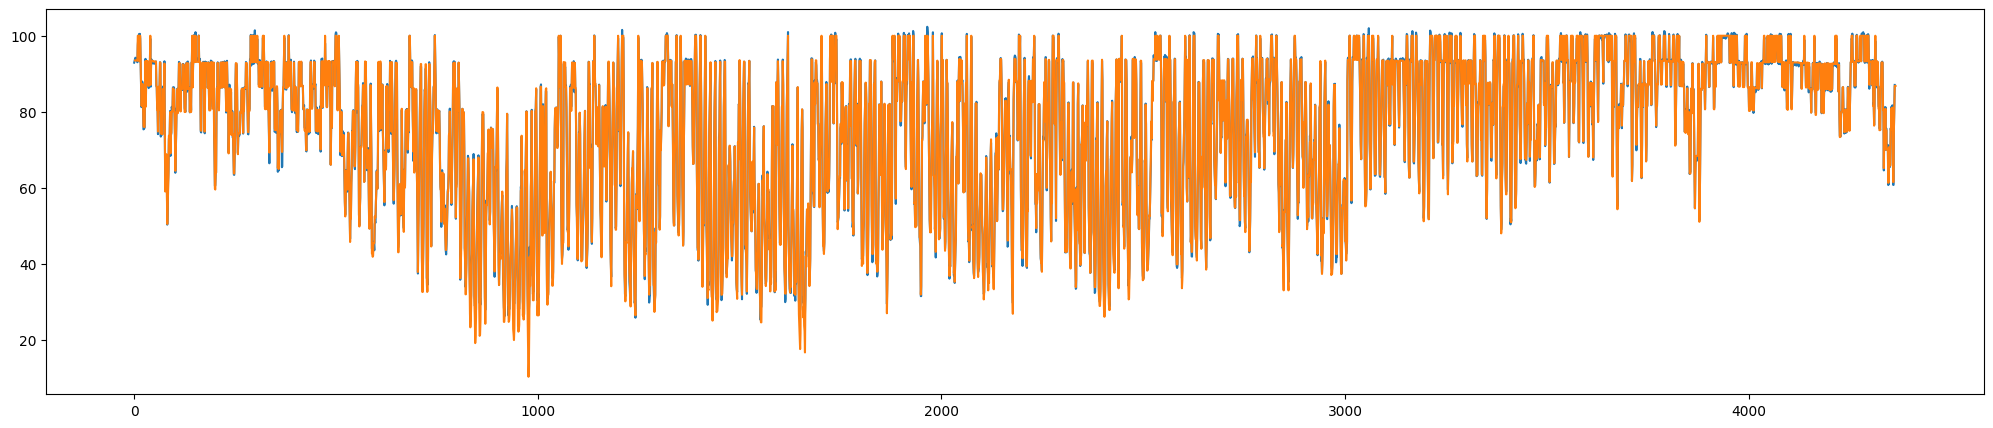

In [78]:
f = plt.figure() 
f.set_figwidth(25) 
f.set_figheight(5) 
plt.plot(y_pred_xgb[["relh"]])
plt.plot(y_test_xgb[["relh"]]) 

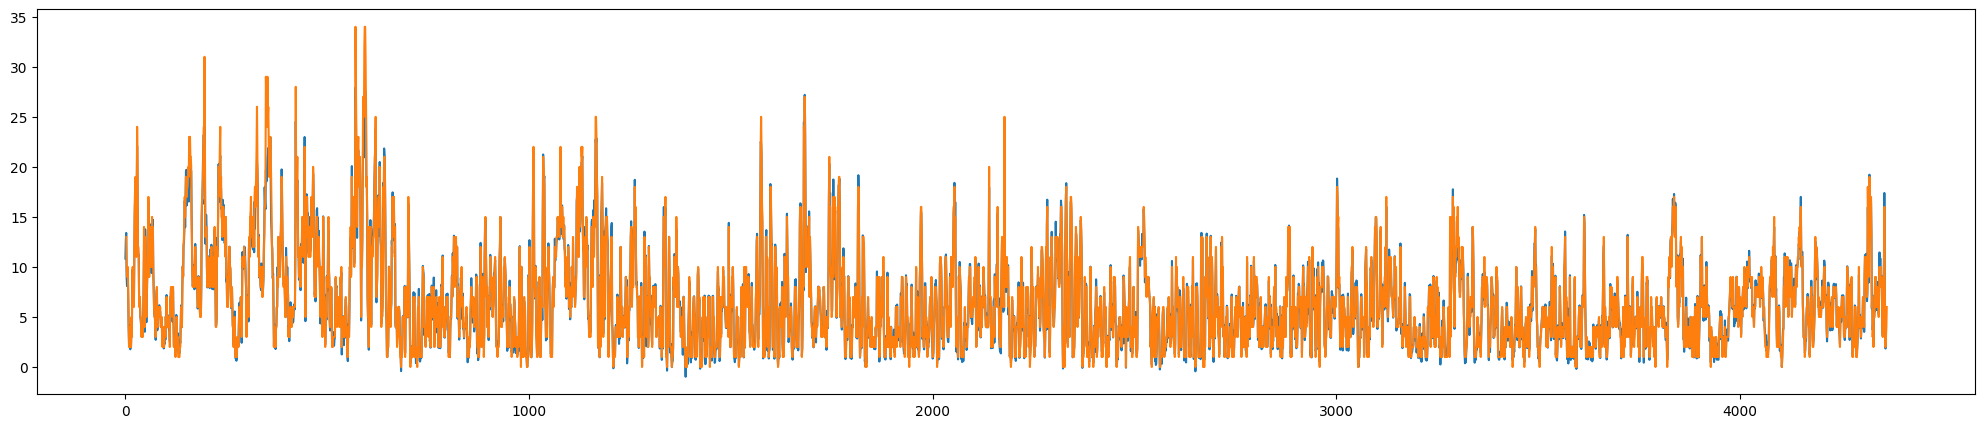

In [79]:
f = plt.figure() 
f.set_figwidth(25) 
f.set_figheight(5) 
plt.plot(y_pred_xgb[["sknt"]])
plt.plot(y_test_xgb[["sknt"]]) 

In [80]:
f = plt.figure() 
f.set_figwidth(25) 
f.set_figheight(5) 
plt.plot(y_pred_xgb[["tempc"]])
plt.plot(y_test_xgb[["tempc"]]) 

KeyError: "None of [Index(['temp'], dtype='object')] are in the [columns]"

<Figure size 2500x500 with 0 Axes>